In [1]:
import pandapower as pp
import pandapower.networks as pn
from pandapower.plotting import simple_plot

import pandas as pd
import numpy as np
import cvxpy as cp
import networkx as nx
from solution_files_manager import SolutionFilesManager

In [2]:
import os
folder = os.path.abspath(os.getcwd())

## Create network

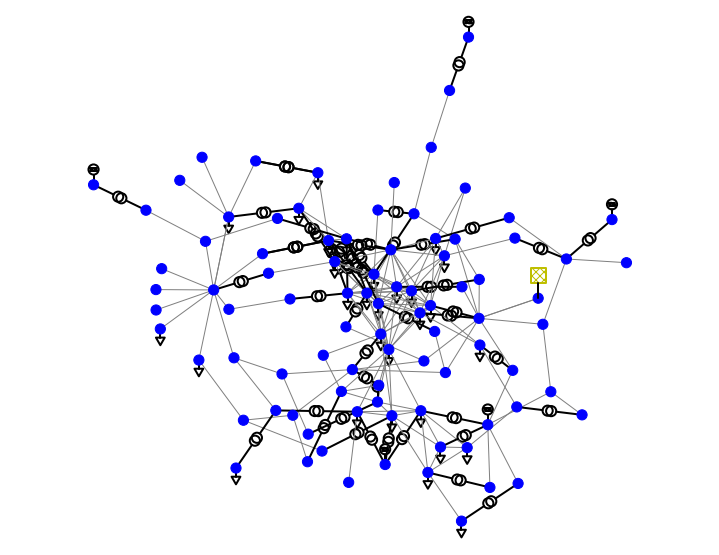

<AxesSubplot:>

In [3]:
case = "case89pegase"
net = getattr(pp.networks, case)()
simple_plot(net, plot_loads=True, plot_sgens=True)

In [4]:
# net.trafo["tap_step_percent"] = np.nan
# net.trafo["tap_side"] = None
# net.trafo["tap_pos"] = np.nan
# net.trafo["tap_neutral"] = 0

# net.trafo.at[0, "tap_step_percent"] = 2.0
# net.trafo.at[1, "tap_step_percent"] = 2.0
# net.trafo.at[10, "tap_step_percent"] = 2.0

#net.trafo["tap_step_percent"] = 10.0
# net.trafo.loc[net.trafo["tap_side"].isna(), ["tap_step_percent"]] = np.nan

# net.trafo["vk_percent"] = 0
# net.trafo["sn_mva"] = 0
# net.trafo["max_loading_percent"] = 0  # no effect

# # deprecated
# net.bus["zone"] = None
# net.load = net.load.drop(["controllable"], axis=1)
# net.load["type"] = "wye"
# net.line.drop(["max_loading_percent"], axis=1)
# net.line["type"] = None
# net.f_hz = 50

# net.line["max_i_ka"] = np.zeros(len(net.line))
# net.line["c_nf_per_km"] = np.zeros(len(net.line))

# # convert all values to p.u.; no longer used

# # parameters
# net.load["p_mw"] = net.load["p_mw"] / net.sn_mva
# net.load["q_mvar"] = net.load["q_mvar"] / net.sn_mva

# net.line["r_ohm_per_km"] = np.array((net.line['r_ohm_per_km'] * net.line["length_km"] * net.sn_mva / net.line['parallel'])) / ((net.bus.loc[net.line.from_bus.values, "vn_kv"].values) ** 2)
# net.line["x_ohm_per_km"] = np.array((net.line['x_ohm_per_km'] * net.line["length_km"] * net.sn_mva / net.line['parallel'])) / ((net.bus.loc[net.line.from_bus.values, "vn_kv"].values) ** 2)

# # bounds
# for col_name in ["max_p_mw", "min_p_mw", "max_q_mvar", "min_q_mvar"]:
#     net.gen[col_name] = net.gen[col_name] / net.sn_mva
#     net.ext_grid[col_name] = net.ext_grid[col_name] / net.sn_mva


# net.bus["vn_kv"] = 1
# net.sn_mva = 1

## Solve

In [5]:
pp.runopp(net, verbose=False, suppress_warnings=True)

OPFNotConverged: Optimal Power Flow did not converge!

In [ ]:
net.res_cost

### Save solution

In [ ]:
V_polar = net.res_bus[["vm_pu", "va_degree"]].to_numpy()
V = V_polar[:,[0]] * np.exp(1j * (V_polar[:,[1]] / 180 * np.pi))

In [ ]:
p_g = np.concatenate((net.res_ext_grid[["p_mw"]].to_numpy(), net.res_gen[["p_mw"]].to_numpy(), net.res_sgen[["p_mw"]].to_numpy())) \
    / net.sn_mva
q_g = np.concatenate((net.res_ext_grid[["q_mvar"]].to_numpy(), net.res_gen[["q_mvar"]].to_numpy(), net.res_sgen[["q_mvar"]].to_numpy())) \
    / net.sn_mva

In [ ]:
# sfm = SolutionFilesManager(folder, case, "orig")
# sfm.save_solution(net.res_cost, V, p_g, q_g)